In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss, cohen_kappa_score, hamming_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
def load_and_preprocess_data(directory):
    data = []
    labels = []

    for i, filename in enumerate(os.listdir(directory)):
        if filename.endswith('.mat'):
            file_path = os.path.join(directory, filename)
            mat_data = sio.loadmat(file_path)
            # print("Keys in the .mat file:", mat_data.keys())
            fmri_data = mat_data['data'][0][0]

            # Flatten the data if it's multidimensional
            flattened_data = fmri_data.flatten()
            data.append(flattened_data)

            # Assign labels based on file order
            if i < 20:
                labels.append(1)  # AD
            elif i < 40:
                labels.append(2)  # MCI
            else:
                labels.append(0)  # Control

    return np.array(data), np.array(labels)

In [3]:
directory = '/content/drive/MyDrive/BMED/'
X, y = load_and_preprocess_data(directory)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

SVM

In [ ]:
pca = PCA(n_components=0.95, random_state=42) #keep components that explain 95% of variance

In [ ]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Train the SVM model with the PCA-transformed data
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_pca, y_train)

# Make predictions on the PCA-transformed test set
y_pred = svm_model.predict(X_test_pca)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"Hamming Loss: {hamming:.2f}")

Model Accuracy: 0.5556
Cohen's Kappa: 0.38
Hamming Loss: 0.44


In [ ]:
# # Compute confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Extract TP, FP, FN, TN
# TP = np.diag(conf_matrix)
# FP = np.sum(conf_matrix, axis=0) - TP
# FN = np.sum(conf_matrix, axis=1) - TP
# TN = np.sum(conf_matrix) - (FP + FN + TP)

# labels = ['AD', 'MCI', 'Control']
# data = {
#     'True Positives': TP,
#     'False Positives': FP,
#     'False Negatives': FN,
#     'True Negatives': TN
# }
# df = pd.DataFrame(data, index=labels)

# # Define a custom color palette
# colors = ['#2ca02c', '#ff7f0e', '#d62728', 'darkblue']  # Blue, Orange, Green, Red

# # Plotting
# fig, ax = plt.subplots(figsize=(12, 6))
# df.plot(kind='bar', ax=ax, width=0.8, color=colors)

# plt.title('Model Performance: TP, FP, FN, TN', fontsize=16)
# plt.xlabel('Classes', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# plt.legend(title='Metrics', title_fontsize='12', fontsize='10')
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Add value labels on the bars
# for container in ax.containers:
#     ax.bar_label(container, padding=3, fontsize=8)

# plt.tight_layout()
# plt.show()

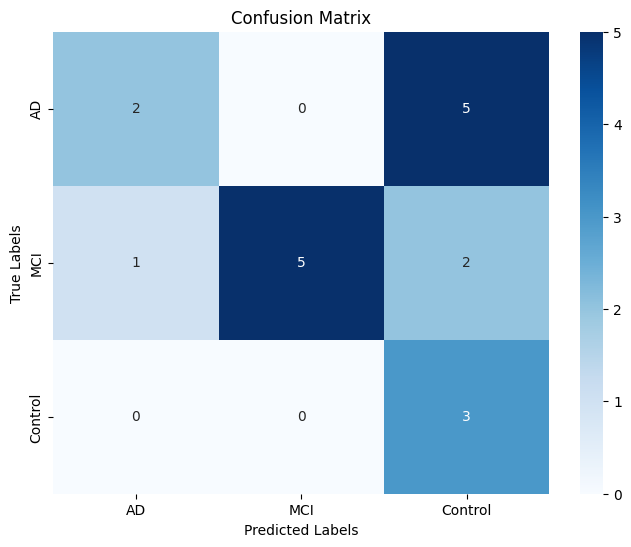

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['AD', 'MCI', 'Control']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# class_report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
# df_class_report = pd.DataFrame(class_report).transpose()

# # Plotting the classification report
# df_class_report.drop(['accuracy'], inplace=True)  # Drop accuracy row for better visualization

# plt.figure(figsize=(10, 6))
# df_class_report[['precision', 'recall', 'f1-score']].round(2).plot(kind='bar', figsize=(10, 6), colormap='viridis')

# plt.title('Classification Report')
# plt.xlabel('Classes')
# plt.ylabel('Scores')
# plt.xticks(rotation=0)
# plt.legend(loc='lower right', fontsize='large')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Add value labels on the bars
# ax = plt.gca()
# for container in ax.containers:
#     ax.bar_label(container, padding=3)

# plt.tight_layout()
# plt.show()

In [ ]:
# Define the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Define RFE for feature selection with the SVM model as the estimator
feature_selector = RFE(estimator=svm_model, n_features_to_select=5)  # Change '10' to the desired number of features

# Create a pipeline that first applies RFE and then trains the SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Standard scaling
    ('feature_selection', feature_selector),
    ('svm', svm_model)
])

# Fit the pipeline on the training data
svm_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_pipeline.predict(X_test)

# Print selected features (useful for interpretation)
selected_features = feature_selector.get_support(indices=True)
print(f"Selected features: {selected_features}")


Selected features: [ 15  20  89 109 110]


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"Hamming Loss: {hamming:.2f}")


Model Accuracy: 0.7222
Cohen's Kappa: 0.59
Hamming Loss: 0.28


In [ ]:
# from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

# # # For binary classification
# # if len(np.unique(y)) == 2:
# #     roc_auc = roc_auc_score(y_test, y_pred[:, 1])
# #     print(f'ROC AUC: {roc_auc}')

# # F1 Score (macro average)
# f1 = f1_score(y_test, y_pred, average='weighted')
# print(f'F1 Score: {f1}')

# # Precision and Recall for each class
# precision = precision_score(y_test, y_pred, average="weighted")
# recall = recall_score(y_test, y_pred, average="weighted")
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')

# # for i, (p, r) in enumerate(zip(precision, recall)):
# #     print(f'Class {i} - Precision: {p}, Recall: {r}')

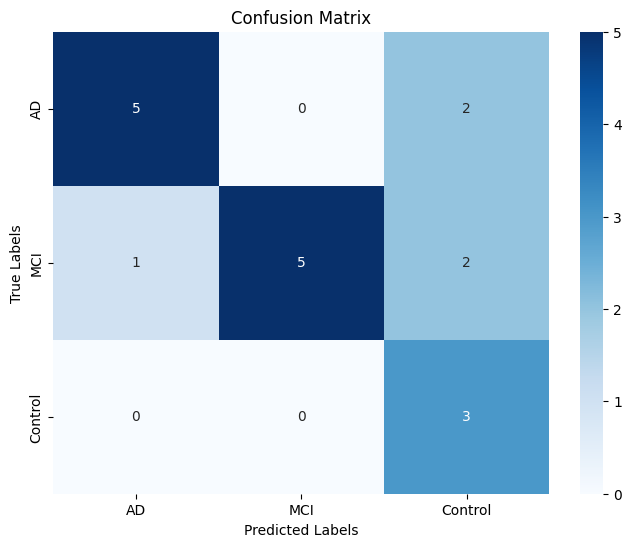

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['AD', 'MCI', 'Control']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# class_report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
# df_class_report = pd.DataFrame(class_report).transpose()

# # Plotting the classification report
# df_class_report.drop(['accuracy'], inplace=True)  # Drop accuracy row for better visualization

# plt.figure(figsize=(10, 6))
# df_class_report[['precision', 'recall', 'f1-score']].round(2).plot(kind='bar', figsize=(10, 6), colormap='viridis')

# plt.title('Classification Report')
# plt.xlabel('Classes')
# plt.ylabel('Scores')
# plt.xticks(rotation=0)
# plt.legend(loc='lower right', fontsize='large')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Add value labels on the bars
# ax = plt.gca()
# for container in ax.containers:
#     ax.bar_label(container, padding=3)

# plt.tight_layout()
# plt.show()

RF

In [ ]:
pca = PCA(n_components=0.95, random_state=42) #keep components that explain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred = rf_model.predict(X_test_pca)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"Hamming Loss: {hamming:.2f}")

Model Accuracy: 0.6667
Cohen's Kappa: 0.47
Hamming Loss: 0.33


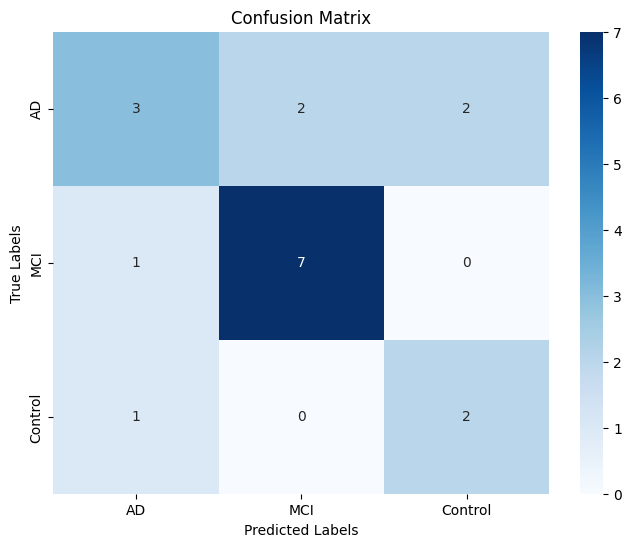

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['AD', 'MCI', 'Control']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# class_report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
# df_class_report = pd.DataFrame(class_report).transpose()

# # Plotting the classification report
# df_class_report.drop(['accuracy'], inplace=True)  # Drop accuracy row for better visualization

# plt.figure(figsize=(10, 6))
# df_class_report[['precision', 'recall', 'f1-score']].round(2).plot(kind='bar', figsize=(10, 6), colormap='viridis')

# plt.title('Classification Report')
# plt.xlabel('Classes')
# plt.ylabel('Scores')
# plt.xticks(rotation=0)
# plt.legend(loc='lower right', fontsize='large')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Add value labels on the bars
# ax = plt.gca()
# for container in ax.containers:
#     ax.bar_label(container, padding=3)

# plt.tight_layout()
# plt.show()

In [ ]:
# from sklearn.metrics import f1_score, precision_score, recall_score
# f1 = f1_score(y_test, y_pred, average='weighted')
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# print(f"F1 Score: {f1:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

# Define RFE for feature selection with Random Forest as the estimator
feature_selector = RFE(estimator=rf_model, n_features_to_select=5)  # Adjust the number of features to select

# Create a pipeline that first applies RFE and then trains the Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', feature_selector),
    ('random_forest', rf_model)
])

# Fit the pipeline on the training data
rf_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_pipeline.predict(X_test)

# Print selected features (useful for interpretation)
selected_features = feature_selector.get_support(indices=True)
print(f"Selected features: {selected_features}")


Selected features: [  1   2   3 111 130]


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
hamming = hamming_loss(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"Cohen's Kappa: {kappa:.2f}")
print(f"Hamming Loss: {hamming:.2f}")

Model Accuracy: 0.78
Cohen's Kappa: 0.64
Hamming Loss: 0.22


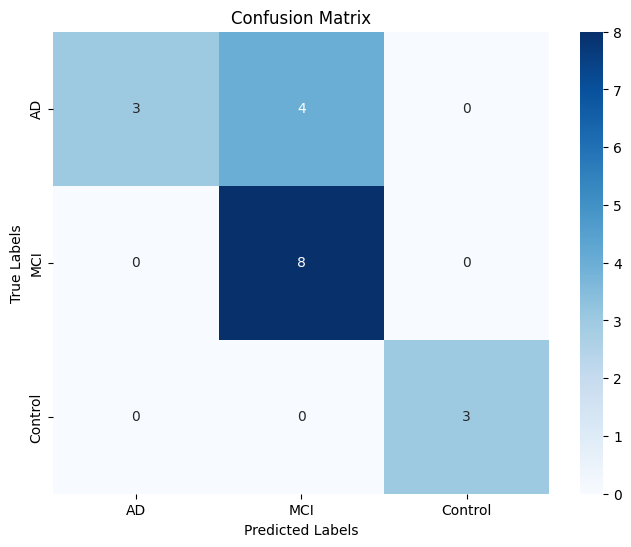

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['AD', 'MCI', 'Control']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# class_report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
# df_class_report = pd.DataFrame(class_report).transpose()

# # Plotting the classification report
# df_class_report.drop(['accuracy'], inplace=True)  # Drop accuracy row for better visualization

# plt.figure(figsize=(10, 6))
# df_class_report[['precision', 'recall', 'f1-score']].round(2).plot(kind='bar', figsize=(10, 6), colormap='viridis')

# plt.title('Classification Report')
# plt.xlabel('Classes')
# plt.ylabel('Scores')
# plt.xticks(rotation=0)
# plt.legend(loc='lower right', fontsize='large')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Add value labels on the bars
# ax = plt.gca()
# for container in ax.containers:
#     ax.bar_label(container, padding=3)

# plt.tight_layout()
# plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Reshape the data
# X is feature array and y is label array
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)

# Build the model
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(140, 1)),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes: AD, MCI, Control
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2158 - loss: 1.1026
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3790 - loss: 1.0781 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2738 - loss: 1.0550 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2738 - loss: 1.0258
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2688 - loss: 1.0036 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3477 - loss: 0.9755 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4578 - loss: 0.9436
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5422 - loss: 0.9091 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6895 - loss: 0.8742
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6791 - loss: 0.8427 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7212 - loss: 0.8299
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.736

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.89      1.00      0.94         8
           2       0.50      0.67      0.57         3

    accuracy                           0.78        18
   macro avg       0.73      0.75      0.73        18
weighted avg       0.79      0.78      0.77        18



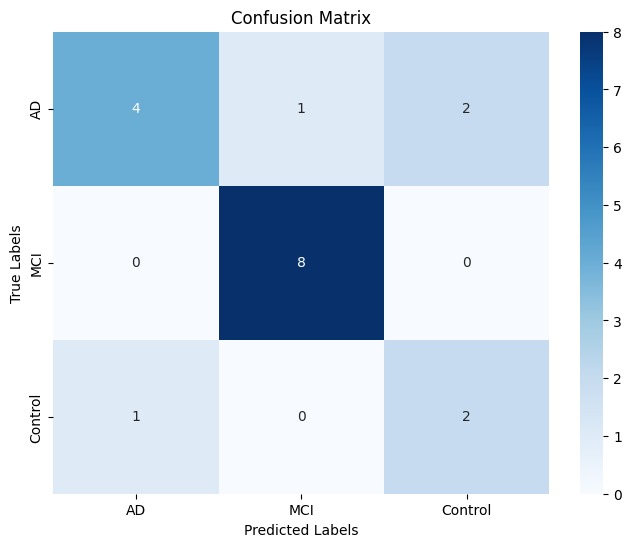

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a trained model and X_test, y_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
labels = ['AD', 'MCI', 'Control']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

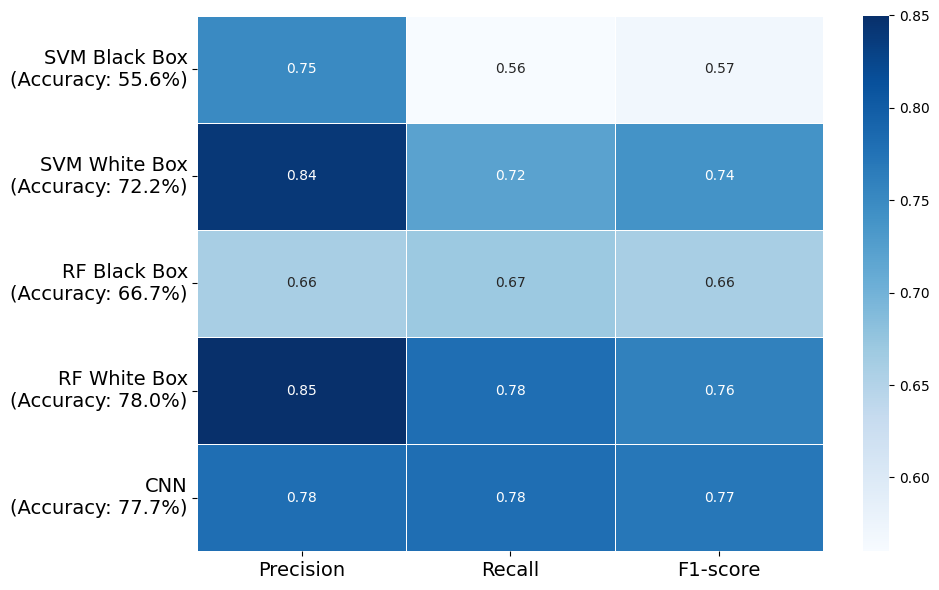

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for the models and their metrics
data = {
    "Model": [
        "SVM Black Box", "SVM White Box",
        "RF Black Box", "RF White Box",
        "CNN"
    ],
    "Accuracy": [55.6, 72.2, 66.7, 78, 77.7],
    "Precision": [0.75, 0.84, 0.66, 0.85, 0.78],
    "Recall": [0.56, 0.72, 0.67, 0.78, 0.78],
    "F1-score": [0.57, 0.74, 0.66, 0.76, 0.77]
}

# Create a DataFrame
df = pd.DataFrame(data)
df.set_index("Model", inplace=True)

heatmap_data = df.drop(columns=["Accuracy"])
accuracy_column = df["Accuracy"]

# Create the heatmap
plt.figure(figsize=(10, 6))
updated_labels = [f"{label}\n(Accuracy: {accuracy_column[label]:.1f}%)" for label in heatmap_data.index]

# Plot the heatmap with updated labels
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)

# Customize y-axis labels
# plt.yticks(
#     ticks=range(len(updated_labels)),
#     labels=updated_labels,
#     rotation=0,
#     fontsize=10,
#     va='center'
# )

plt.gca().set_yticklabels(updated_labels, rotation=0, fontsize=14, va='center')

# Heatmap title and labels
#plt.title("Performance Metrics Heatmap for Different Models", fontsize=16)
#plt.xlabel("Metrics", fontsize=12)
plt.ylabel("")
plt.xticks(fontsize=14)

# Show the heatmap
plt.tight_layout()
plt.show()